# Introduction

Image Classification task with HuggingFace Transformers

# Installing dependencies

In [ ]:
!pip install datasets transformers

# Downloading dataset & preprocessing

## Loading

> Loading Animals-10 dataset from HuggingFace

>> [Official page](https://huggingface.co/datasets/Rapidata/Animals-10) for more details

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Rapidata/Animals-10")

README.md:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23554 [00:00<?, ? examples/s]

> Grabing a few samples randomly

In [ ]:
test_ds = dataset['train'].shuffle(1024).select(range(5))

> Defining classes list based on the labels ids

In [ ]:
classes = ['Butterfly', 'Cat', 'Chicken', 'Cow', 'Dog', 'Elephant', 'Horse', 'Sheep', 'Spider', 'Squirrel']

## Preprocessing

> Importing auto image processor for ResNet50 model and preprocessing the inputs

In [ ]:
from transformers import AutoImageProcessor

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
inputs = processor(test_ds['image'], return_tensors="pt")

# Loading the model

## Model description

ResNet (Residual Network) is a convolutional neural network that democratized the concepts of residual learning and skip connections. This enables to train much deeper models.

It was introduced in the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) by He et al.

## Loading pre-trained ResNet50 model

In this case we use ResNet50 model that pre-trained on ImageNet-1k at resolution 224x224.

In [ ]:
from transformers import ResNetForImageClassification
import torch

model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# Predict

## Predicting

In [ ]:
with torch.no_grad():
    logits = model(**inputs).logits

## Plotting the result

> Defining a function to plot inputs with actual and predicted labels along with confidence scores.

In [ ]:
import math
from PIL import ImageDraw, ImageFont, Image

def show_examples(examples,
                  predictions,
                  model,
                  classes: list,
                  columns: int = 3,
                  size: tuple = (350, 350)):

    rows = int(math.ceil(examples.shape[0] / columns))
    w, h = size

    grid = Image.new('RGB', size=(columns * w, rows * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 16)

    # Plot the example with actual label, pred label and confidence score
    for i, pred in enumerate(predictions):
        image = examples[i]['image']

        # actual label in dataset
        ds_label = classes[examples[i]['label']]

        # predicted label decoding
        predicted_label_index = pred.argmax(-1).item()
        predicted_label = model.config.id2label[predicted_label_index]

        # predicted label confidence score
        probabilities = torch.softmax(pred, dim=-1)
        confidence_score = probabilities[predicted_label_index].item()

        # defining plotting box offset
        box = (i % columns * w, i // columns * h)

        # plotting image to box area
        grid.paste(image.resize(size), box=box)

        # putting the result on the image
        draw.text((box[0] + 10, box[1] + 5), # box with some padding
                  f"ds label: {ds_label}",
                  (255, 255, 255),
                  font=font,
                  stroke_width=2,
                  stroke_fill=(0, 0, 0))
        draw.text((box[0] + 10, box[1] + 25),
                  f"pred label: {predicted_label}",
                  (255, 255, 255),
                  font=font,
                  stroke_width=2,
                  stroke_fill=(0, 0, 0))
        draw.text((box[0] + 10, box[1] + 45),
                  f"conf score: {confidence_score:.2f}",
                  (255, 255, 255),
                  font=font,
                  stroke_width=2,
                  stroke_fill=(0, 0, 0))

    return grid

> Displaying the results

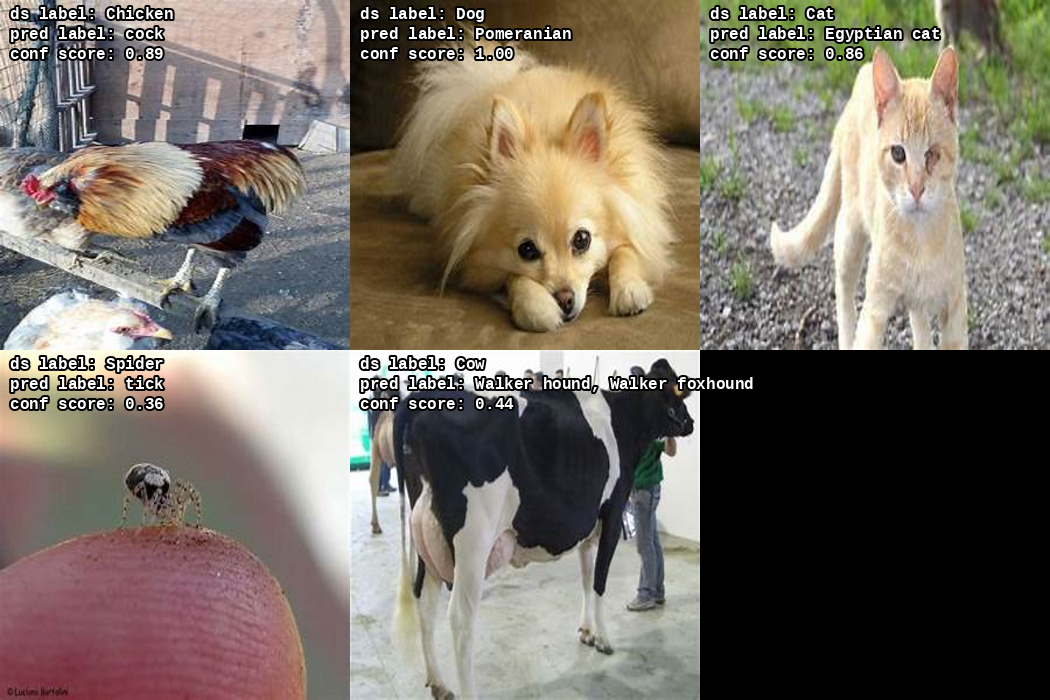

In [ ]:
show_examples(test_ds, logits, model, classes)

# Conclusion


The model's performance is sufficient, but it performed poorly on a few images. We can boost the performance by fine-tuning the model on the specified dataset.